# Predicting year of origin for famous works of art with a convolutional neural net
Liza Daly, May 2017

<img src="https://github.com/lizadaly/guesso/blob/master/images/header.png?raw=true" />

Using PyTorch, I took a [pretrained ResNet50 model](http://pytorch.org/docs/torchvision/models.html) and further trained it on a collection of 40,000 images of works of art from the openly licensed collections at [Rijksmuseum](https://rijksmuseum.github.io/) and [The Metropolitan Museum of Art](https://github.com/metmuseum/openaccess). 

Each image was paired with its best-known year of origin (not all works have exact dates; I grabbed the earliest date where the museum metadata included a range). This simplified image data is available in the `metadata` directory of this repository. 

Note that I haven't included the images themselves—the full collection is more than 150GB. Use the IDs provided in the metadata along with the instructions and terms of use for the museum APIs to acquire them. 

(I've never worked with convolutional neural networks before, so take this as an example of a beginner's exploration rather than any sort of best practice.)

## Results

After 35 epochs, training loss using mean-squared error was 0.75 and validation loss was 3.81 (on 10% of the total corpus). 

My hand-wavy goal was that network would make reasonable guesses and, on average, would be better than me if I were just standing in a museum. Across the whole dataset of images from the year 1250 to 1930, the model was off by an average of 74 years. See below for some details about where it did better and worse.


In [1]:
%matplotlib inline 
import random

import pandas as pd
import seaborn as sns
sns.set(style="white")
import matplotlib.pyplot as plt
import math
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
from IPython.core.display import HTML 

from guess import predict_by_url

## Filtering the training results
There are far fewer training examples below the year 1500, so for the sake of more readable graphs, I cut the tail out while stil preserving some fairly old examples.

In [2]:
df = pd.read_csv('results.csv')
df = df.loc[df.year > 1500]
years = df.year.max() - df.year.min()
# Round down to the nearest 50 years for display
df['rounded'] = df.year.apply(lambda x: int(math.floor(x / 50) * 50))

In [3]:
"Average error for this time slice, in years: %d" % int(df['diff'].mean())

'Average error for this time slice, in years: 71'

## Distribution of works by age
These collections are skewed towards a little recent, so we might expect the model to guess more often in the 1800-1900 range. There's a bump in the 1600 range because the Rijksmuseum has so many Dutch masters from that period.

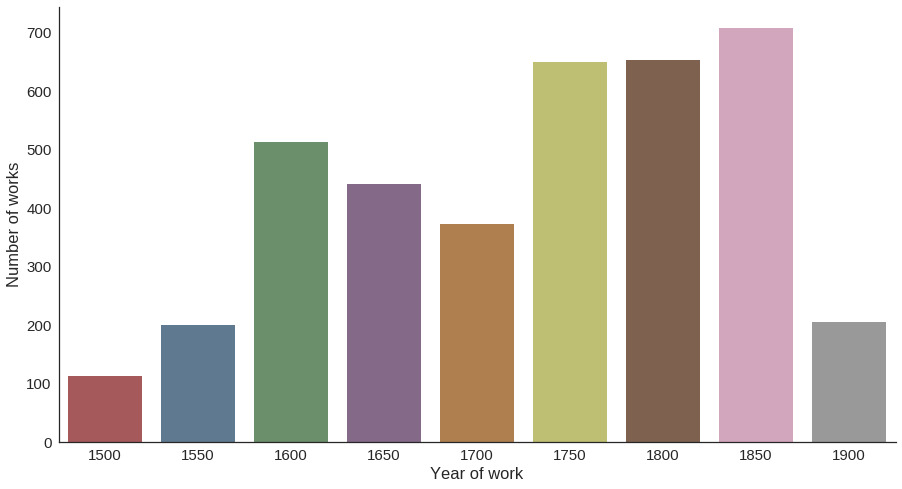

In [4]:
plt.figure(figsize=(15,8))
sns.set_context("notebook", font_scale=1.5)
pt = sns.countplot(x='rounded', data=df, palette=sns.color_palette("Set1", n_colors=11, desat=.5))
pt.set(xlabel="Year of work", ylabel="Number of works")
sns.despine()

## Distribution of errors
This violin plot compares the age of the work by the model's error—how much was the guess off from the true year? (The wider the blob, the more guesses fell into that range). Unsurprisingly, it's almost an inverse of the graph above: the more data we had, the more the guesses pool at the bottom of the error range. In other words, it's more accurate the more examples it had to work with, with the edges having the most error.

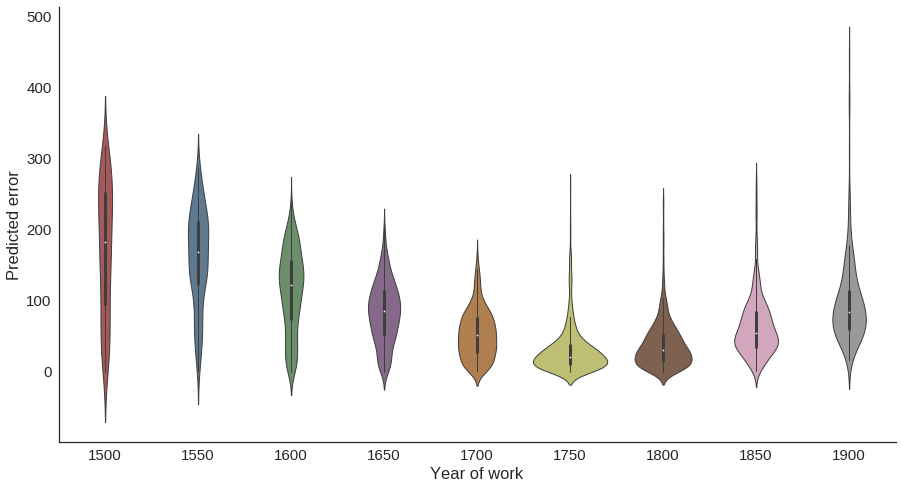

In [5]:
plt.figure(figsize=(15,8))
sns.set_context("notebook", font_scale=1.5)
pt = sns.violinplot(x='rounded', y='diff', data=df, linewidth=1, palette=sns.color_palette("Set1", n_colors=11, desat=.5))
pt.set(xlabel="Year of work", ylabel="Predicted error")
sns.despine()

In [6]:
df = df.sort_values('diff')
hits = df.iloc[0:50]
misses = df.tail(100)

In [7]:
def generate_image_set(df, num_images=5):
    if hasattr(df, 'path'):
        images = [(Image.open(row.path).convert('RGB'), row.year, row.pred) for row in df.itertuples()]
    else:
        images = [(row.img, row.year, row.pred) for row in df.itertuples()]
    [img.thumbnail((400, 400)) for img, _, _ in images]
    width = 250; height = 250
    images = [(img.crop((img.size[0] / 2 - width/2, img.size[1] / 2 - height/2, 
                        img.size[0] / 2 + width/2, img.size[1] / 2 + height/2)), year, pred) for img, year, pred in images]
    images = random.sample(images, min(len(images), num_images))
    fnt = ImageFont.truetype('/media/liza/ext-drive/liza/fonts/StagSans-Book.otf', 30)
    im = Image.new('RGB', (num_images * width, height), (255, 255, 255))
    x_offset = 0
    for img, year, pred in images:
        draw = ImageDraw.Draw(img)
        draw.rectangle((0, height - 35, 5 * width, height), fill=(50, 50, 50))
        draw.line((width, 0, width, height), width=10, fill=(255, 255, 255))
        draw.text((10, height - 30), str(year), fill=(200, 200, 100), font=fnt)
        draw.text((180, height - 30), str(pred), fill=(100, 200, 200), font=fnt)
        im.paste(img, (x_offset, 0))
        x_offset += 250

    return im

## Inspecting the results 

### The yellow number on the left is the actual date of the piece. The blue number on the right is the guess.

First, let's take a sample from the top 50 by accuracy.

It tends to do really well with drawings, I think in part because museum drawing collections tend to come in series. There are often lots of sketches by the same artist that will be on the same paper with similar aging properties. But that's valid; those are all qualities that an expert would use to evaluate a date. 

The model is also pretty good at Dutch masters (there are lots of examples in the Rijksmuseum data) and etchings (very likely to be 16th century).

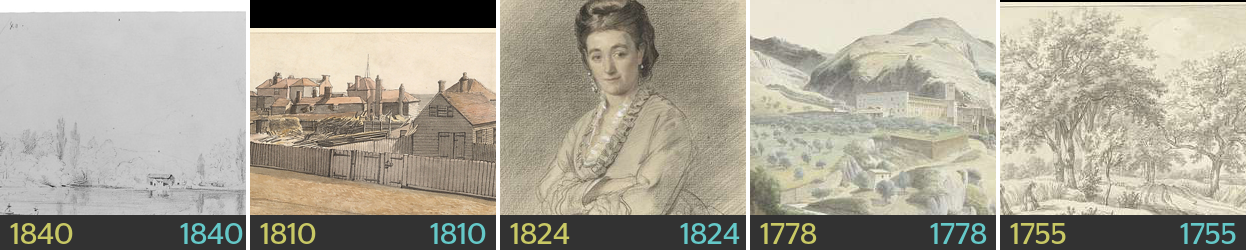

In [8]:
generate_image_set(hits)

Sampling from the bottom of the range gets us guesses that are hundreds of years off from the true value. These tend to be examples that don't necessarily fit the training data well—including some bad metadata where images of sculpture snuck in, or non-European works. Neural network models are only as culturally sensitive as their datasets. It tends to do poorly with recent (1890+) works, likely due to the combination of a real explosion in style and the smaller number of samples.

First, examples where the model thought the work was much older than it really was:

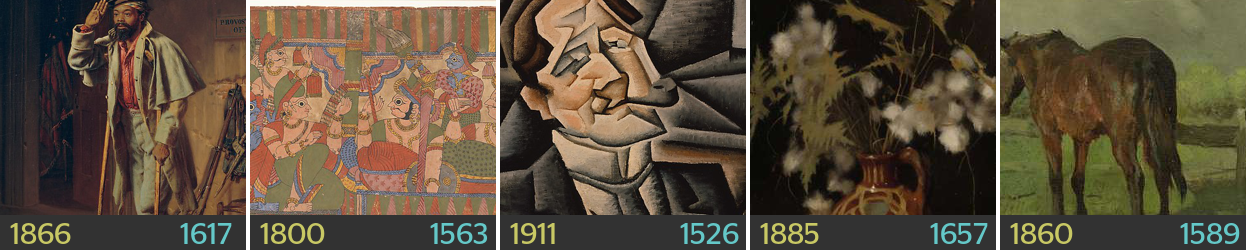

In [30]:
generate_image_set(misses.loc[misses.pred < misses.year])

Examples where it thought the work was much more recent than it was tend to be very early drawings. I think there's just not enough visual information for the model to work with, so it gravitates towards the most-likely years.

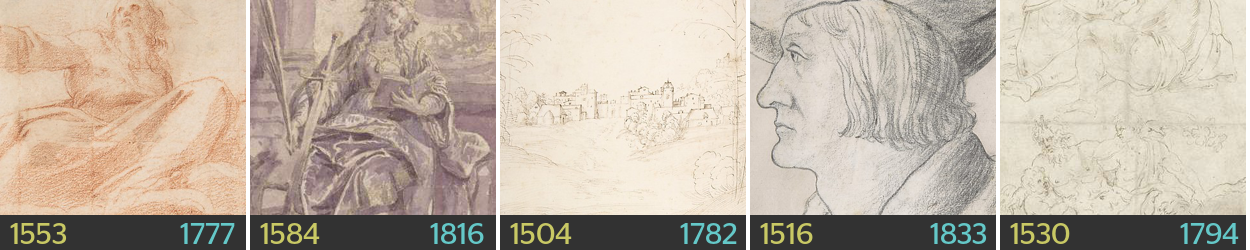

In [27]:
generate_image_set(misses.loc[misses.pred > misses.year])

Just looking at the works after 1900 without regard for performance demonstrates what a tough task this—this stuff is all over the place, stylistically. We'd need a much better set of training examples of 20th century art to expect good results here. Alas, copyright.

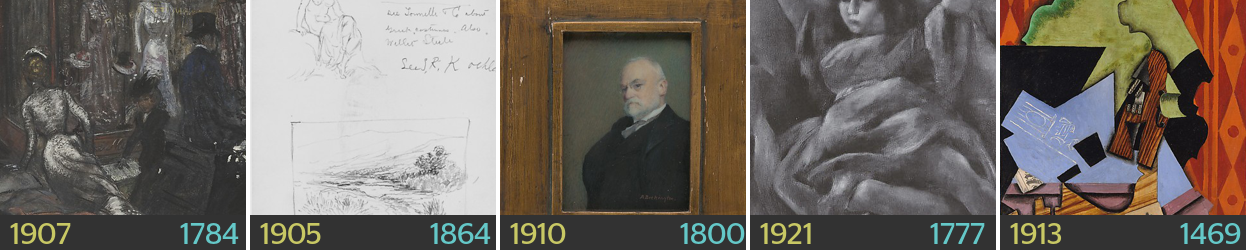

In [31]:
generate_image_set(df.loc[df['year'] > 1900])

It does seem to get impressionism, at least—the recent works where it guessed within 40 years of truth tend to be impressionistic. 

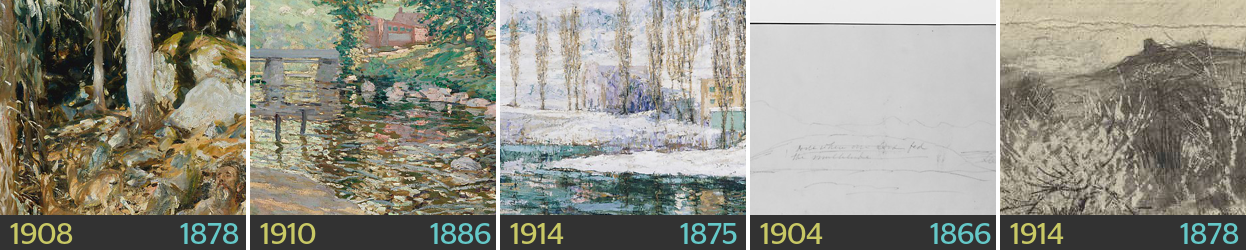

In [41]:
generate_image_set(df.loc[(df['diff'] < 40) & (df['year'] > 1900)])

In [33]:
famous_paintings = [{'year': 1892, 'url': 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/bd/Paul_Gauguin%2C_Nafea_Faa_Ipoipo%3F_%28When_Will_You_Marry%3F%29_1892%2C_oil_on_canvas%2C_101_x_77_cm.jpg/901px-Paul_Gauguin%2C_Nafea_Faa_Ipoipo%3F_%28When_Will_You_Marry%3F%29_1892%2C_oil_on_canvas%2C_101_x_77_cm.jpg'},
                   {'year': 1907, 'url': 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Gustav_Klimt_046.jpg/1197px-Gustav_Klimt_046.jpg'},
                   {'year': 1526, 'url': 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Darmstadtmadonna.jpg/846px-Darmstadtmadonna.jpg'},
                   {'year': 1664, 'url': 'https://upload.wikimedia.org/wikipedia/commons/c/c8/Vermeer_The_concert.JPG'},
                   {'year': 1633, 'url': 'https://upload.wikimedia.org/wikipedia/commons/f/f3/Rembrandt_Christ_in_the_Storm_on_the_Lake_of_Galilee.jpg'},
                   {'year': 1886, 'url': 'https://upload.wikimedia.org/wikipedia/commons/e/ee/Van_Gogh_-_Vase_mit_Pechnelken.jpeg'}, 
                   {'year': 1888, 'url': 'https://upload.wikimedia.org/wikipedia/commons/b/bc/Girl_in_Front_of_Open_Window.jpg'},
                   {'year': 1514, 'url': 'https://upload.wikimedia.org/wikipedia/commons/9/95/Raphael_missing.jpg'},
                   {'year': 1503, 'url': 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/804px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg'},
                   {'year': 1607, 'url': 'https://upload.wikimedia.org/wikipedia/commons/b/b1/CaravaggioJeromeValletta.jpg'}]

In [16]:
results = []
for p in famous_paintings:
    pred, img = predict_by_url(p['url'])
    results.append({'pred': pred, 'img': img, 'year': p['year']})


## Famous paintings
Lastly, a bit of a torture test: I asked it to evaluate 10 ultra-famous paintings that have at one point been stolen. Almost by definition, these works defied the conventions of their eras and ought to be tough to place on style alone.

Still, it does OK on the two works that tend towards impressionism. But my favorite failure is the Klimt—the model's guess is wildly old, something it tends not to do because of the scarity of pre-1500 examples. I can only assume it mistook the color scheme for gold leaf.

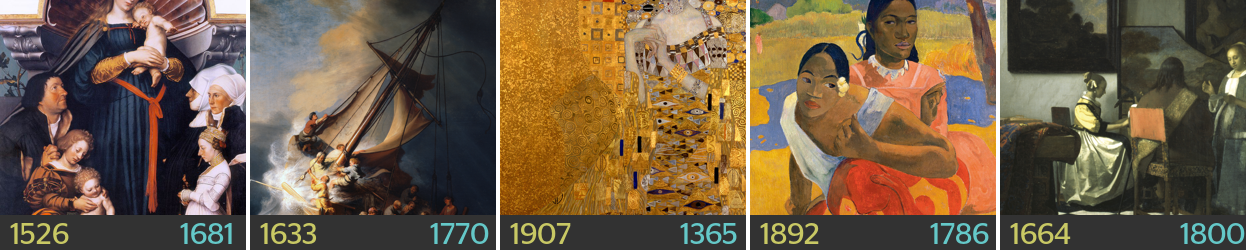

In [17]:
generate_image_set(pd.DataFrame(results[0:5]))

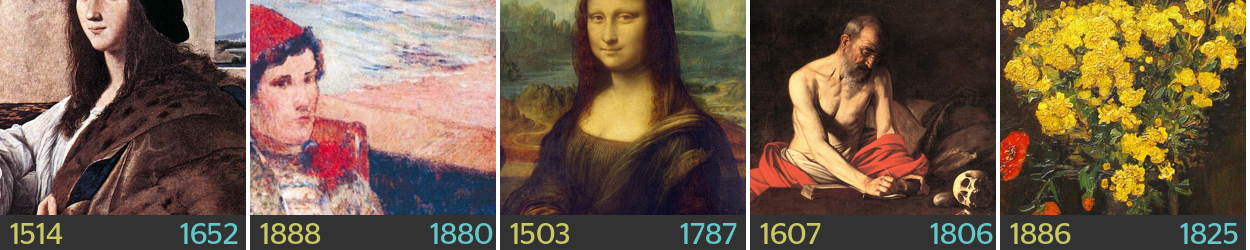

In [18]:
generate_image_set(pd.DataFrame(results[5:]))